In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from tensorflow.keras import layers, activations, losses, optimizers
from tensorflow.keras.models import Model
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

In [2]:
def vec_product(v1, v2):
    return v1[0]*v2[1] - v1[1]*v2[0]


def in_rectangle(a, b, c, d, dot):
    v1, v2, v3, v4 = a-dot, b-dot, c-dot, d-dot
    return vec_product(v1, v2) <= 0 and vec_product(v2, v3) <= 0 and \
            vec_product(v3, v4) <= 0 and vec_product(v4, v1) <= 0


def draw_rectangle(X, coordinate_x, coordinate_y, length, width, angle, colour, need_noise, noise):
    side = X.shape[0]
    rotation_matrix = np.asmatrix(np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]))
    
    # initialize
    a = np.array([0., 0.])
    b = np.array([length*1., 0.])
    c = np.array([length*1., width*1.])
    d = np.array([0., width*1.])
    
    # rotate
    a = np.resize((rotation_matrix @ a), (2,))
    b = np.resize((rotation_matrix @ b), (2,))
    c = np.resize((rotation_matrix @ c), (2,))
    d = np.resize((rotation_matrix @ d), (2,))
    
    # move to the first quadrant
    min_coord = np.amin([a, b, c, d], axis=0)
    a -= min_coord
    b -= min_coord
    c -= min_coord
    d -= min_coord

    # cast to integer
    a = a.astype(np.int64)
    b = b.astype(np.int64)
    c = c.astype(np.int64)
    d = d.astype(np.int64)
    
    # shift
    a[0] += coordinate_x
    a[1] = coordinate_y - a[1]
    b[0] += coordinate_x
    b[1] = coordinate_y - b[1]
    c[0] += coordinate_x
    c[1] = coordinate_y - c[1]
    d[0] += coordinate_x
    d[1] = coordinate_y - d[1]
    
    # clip
    a = np.clip(a, 0, side-1)
    b = np.clip(b, 0, side-1)
    c = np.clip(c, 0, side-1)
    d = np.clip(d, 0, side-1)
    
    # max/min
    max_coord = np.amax([a, b, c, d], axis=0)
    min_coord = np.amin([a, b, c, d], axis=0)
    area = (max_coord[0]-min_coord[0]+1)*(max_coord[1]-min_coord[1]+1)
    
    # draw
    for x in range(min_coord[0], max_coord[0]+1):
        for y in range(min_coord[1], max_coord[1]+1):
            if in_rectangle(a, b, c, d, np.array([x, y])):
                X[y, x] = colour
                if need_noise:
                    noise[y, x] = colour
    
    return X, area, noise

In [3]:
def independent_noise(X, percentage, length_boundary, width_coef, colour, need_noise=False):
    noise = []
    if need_noise:
        noise = np.zeros(X.shape)
    side = X.shape[0]
    noise_area = 0
    while noise_area/(side**2) < percentage:
        length = np.random.randint(3, length_boundary)
        width = int(width_coef*length)
        angle = np.random.rand(1)*np.pi
        bound = np.maximum(length, width)
        coordinates = np.random.randint(0, side-bound, 2)
        X, area, noise = draw_rectangle(X, coordinates[0], coordinates[1]+bound, 
                                 length, width, angle, colour, need_noise, noise)
        noise_area += area
    return X, noise

In [4]:
def dependent_noise(X, percentage, window, colour, need_noise=False):
    noise = []
    if need_noise:
        noise = np.zeros(X.shape)
    side = X.shape[0]
    angles = [np.pi/6, 5*np.pi/6, np.pi/4, 3*np.pi/4, np.pi/3, 2*np.pi/3, np.pi/2, np.pi]
    noise_area = 0
    rounds = 0
    max_rounds = 1000 # maximum number of loops
    while noise_area/(side**2) < percentage and rounds < max_rounds:
        rounds += 1
        # indicates that line suits
        suit = False
        # generate coordinates
        coordinates = np.random.randint(0, side-window, 2)
        # generate angles
        np.random.shuffle(angles)
        # trying to cross the borders with lines with different angles
        for angle in angles:
            # make line
            tan = np.tan(angle)
            cotan = np.tan(np.pi/2 - angle)
            if np.abs(tan) <= 1:
                x = np.arange(-window//2, window//2)
                y = x * tan
                mask = (y > -window/2.) & (y < window/2.)
            else:
                y = np.arange(-window//2, window//2)
                x = y * cotan
                mask = (x > -window/2.) & (x < window/2.)
            # shift with window
            x = np.clip(x + window//2, 0, window - 1)
            y = np.clip(window//2 - y, 0, window - 1)
            # shift with coordinates
            x = np.clip(x + coordinates[0], 0, side - 1)
            y = np.clip(y + coordinates[1], 0, side - 1)
            I = y[mask].astype(np.int64)
            J = x[mask].astype(np.int64)
            # check for crossing
            previous = 0
            cross = 0
            for itr, (i, j) in enumerate(zip(I, J)):
                if itr != 0:
                    if cross == 0 and previous >= colour*0.25 and colour*0.75 >= X[i,j]:
                        cross += 1
                    elif cross > 0 and previous <= colour*0.25 and colour*0.75 <= X[i,j]:
                        suit = True
                        break
                previous = X[i,j]
            # if line suits, draw it
            if suit:
                sin = np.sin(angle)
                cos = abs(np.cos(angle))
                if np.abs(tan) <= 1:
                    length = int(window/abs(np.cos(angle)))
                else:
                    length = int(window/np.sin(angle))
                width = length//2
                coordinates[0] += window//2
                coordinates[0] -= int(cos*length/2+(cos**2)*sin*width)
                coordinates[1] += window//2
                coordinates[1] += int(sin*length/2+(sin**2)*cos*width)
                X, area, noise = draw_rectangle(X, coordinates[0], coordinates[1], 
                                                length, width, angle, colour, 
                                                need_noise, noise)
                noise_area += area
                break
    return X, noise

In [5]:
def data_loader(file_name, dataset_name_list, batch_size, noise_mode):        
    for dataset_name in dataset_name_list:
        with h5py.File(file_name, 'r') as f:
            dataset_length = f[dataset_name].shape[0]
        current_index = 0
        next_index = 0
        while current_index < dataset_length:
            next_index = min(current_index+batch_size, dataset_length)
            with h5py.File(file_name, 'r') as f:
                im_batch = f[dataset_name][current_index : next_index]/255.
            if noise_mode == 'dependent':
                for i in range(next_index-current_index):
                    im_batch[i] = dependent_noise(im_batch[i], percentage=0.2, window=30, colour=1.)[0]
            else:
                for i in range(next_index-current_index):
                    im_batch[i] = independent_noise(im_batch[i], percentage=0.2, 
                                                    length_boundary=30, width_coef=0.5, colour=1.)[0]
            im_batch = tf.convert_to_tensor(im_batch, dtype=tf.float32)
            im_batch = im_batch[..., tf.newaxis]
            with h5py.File(file_name, 'r') as f:
                gt_batch = f[dataset_name][current_index : next_index]/255.
            gt_batch = tf.convert_to_tensor(gt_batch, dtype=tf.float32)
            gt_batch = gt_batch[..., tf.newaxis]
            yield (im_batch, gt_batch)
            current_index = next_index
            

file_name = 'isbi12_data.hdf5'
train_data_set_list = ['augmented/tile/train', 'augmented/random/train']
test_data_set_list = ['augmented/tile/test', 'augmented/random/test']
noise_mode = 'independent'

In [6]:
class denoising_autoencoder(Model):
    def __init__(self, dim, first_dense_layer, second_dense_layer):
        super(denoising_autoencoder, self).__init__()
        
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(dim, dim, 1)),
            layers.Conv2D(4, (3, 3), activation='relu'), 
            layers.Conv2D(8, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(first_dense_layer, activation='relu'),
            layers.Dense(second_dense_layer, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(first_dense_layer, activation='relu'),
            layers.Dense(8*(dim-4)**2, activation='relu'),
            layers.Reshape((dim-4, dim-4, 8)),
            layers.Conv2DTranspose(4, (3,3), activation='relu'),
            layers.Conv2DTranspose(1, (3,3), activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = denoising_autoencoder(128, 2**8, 2**6)

In [7]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 4)       40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 8)       296       
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               31490304  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
Total params: 31,507,088
Trainable params: 31,507,088
Non-trainable params: 0
_________________________________________________________________


In [8]:
# =============================================================================
# Created By : Mathieu Carriere
# Link : https://github.com/MathieuCarriere/difftda/blob/master/difftda.py
# Article: Carriere et al. "Optimizing persistent homology based functions." 
#          International Conference on Machine Learning (2021)
# =============================================================================

######################
# Cubical filtration #
######################

# The parameters of the model are the pixel values.

def Cubical(X, dim, card):
    # Parameters: X (image),
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    cc = gd.CubicalComplex(dimensions=X.shape, top_dimensional_cells=X.flatten())
    cc.persistence()

    try:
        cof = cc.cofaces_of_persistence_pairs()[0][dim]
    except IndexError:
        cof = np.array([])
        
    Xs = X.shape

    if len(cof) > 0:
        # Sort points with distance-to-diagonal
        pers = [X[np.unravel_index(cof[idx,1], Xs)] - X[np.unravel_index(cof[idx,0], Xs)] for idx in range(len(cof))]
        perm = np.argsort(pers)
        cof = cof[perm[::-1]]
    
    # Retrieve and ouput image indices/pixels corresponding to positive and negative simplices
    D = len(Xs)
    ocof = np.array([0 for _ in range(D*card*2)])
    count = 0
    for idx in range(0,min(2*card, 2*cof.shape[0]),2):
        ocof[D*idx:D*(idx+1)]     = np.unravel_index(cof[count,0], Xs)
        ocof[D*(idx+1):D*(idx+2)] = np.unravel_index(cof[count,1], Xs)
        count += 1
    return list(np.array(ocof, dtype=np.int32))

class CubicalModel(tf.keras.Model):
    def __init__(self, X, dim=1, card=50):
        super(CubicalModel, self).__init__()
        self.X = X
        self.dim = dim
        self.card = card
        
    def call(self):
        d, c, D = self.dim, self.card, len(self.X.shape)
        XX = tf.reshape(self.X, [1, self.X.shape[0], self.X.shape[1]])
        
        # Turn numpy function into tensorflow function
        CbTF = lambda X: tf.numpy_function(Cubical, [X, d, c], [tf.int32 for _ in range(2*D*c)])
        
        # Compute pixels associated to positive and negative simplices 
        # Don't compute gradient for this operation
        inds = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(CbTF,XX,dtype=[tf.int32 for _ in range(2*D*c)]))
        
        # Get persistence diagram by simply picking the corresponding entries in the image
        dgm = tf.reshape(tf.gather_nd(self.X, tf.reshape(inds, [-1,D])), [-1,2])
        return dgm

In [9]:
# def swd(dgm1, dgm2):
#     dgm1_pr = tf.map_fn(
#         lambda dot: tf.convert_to_tensor([tf.reduce_sum(dot)/2, tf.reduce_sum(dot)/2], dtype=tf.float32),
#         dgm1
#     )
#     dgm2_pr = tf.map_fn(
#         lambda dot: tf.convert_to_tensor([tf.reduce_sum(dot)/2, tf.reduce_sum(dot)/2], dtype=tf.float32),
#         dgm2
#     )
#     dgm1 = tf.concat([dgm1, dgm2_pr], axis=0)
#     dgm2 = tf.concat([dgm2, dgm1_pr], axis=0)
#     size = dgm1.shape[0]
#     swd = 0
#     m = 5
#     angle = np.pi/m
#     rotate = np.asmatrix([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
#     vector = np.asarray([-1., 0.])
#     for i in range(m):
#         tf_vector = tf.convert_to_tensor(vector, dtype=tf.float32)
#         v1 = tf.map_fn(
#             lambda dot: tf.tensordot(dot, tf_vector, axes=1),
#             dgm1
#         )
#         v2 = tf.map_fn(
#             lambda dot: tf.tensordot(dot, tf_vector, axes=1),
#             dgm2
#         )
#         v1 = tf.sort(v1)
#         v2 = tf.sort(v2)
#         swd += tf.norm(v1-v2, ord=1)
#         vector = np.asarray((rotate@vector)).flatten()
#     return swd/np.pi

In [20]:
def loss_function(im_batch, gt_batch):
    alpha = 1
    beta0 = 0.005
    beta1 = 0.005
    loss = []
    for im, gt in zip(im_batch, gt_batch):
        im_cub_model_0 = CubicalModel(tf.squeeze(im), dim=0, card=15)
        gt_cub_model_0 = CubicalModel(tf.squeeze(gt), dim=0, card=15)
        im_dgm_0 = im_cub_model_0.call()
        gt_dgm_0 = gt_cub_model_0.call()
        wd_0 = wasserstein_distance(im_dgm_0, gt_dgm_0, enable_autodiff=True, keep_essential_parts=False)#swd(im_dgm_0, gt_dgm_0)
        im_cub_model_1 = CubicalModel(tf.squeeze(im), dim=1, card=10)
        gt_cub_model_1 = CubicalModel(tf.squeeze(gt), dim=1, card=10)
        im_dgm_1 = im_cub_model_1.call()
        gt_dgm_1 = gt_cub_model_1.call()
        wd_1 = wasserstein_distance(im_dgm_1, gt_dgm_1, enable_autodiff=True, keep_essential_parts=False)#swd(im_dgm_1, gt_dgm_1)
        one_loss = alpha*tf.reduce_mean(tf.math.square(gt-im)) + beta0*wd_0 + beta1*wd_1
        loss.append(one_loss)
    return tf.reduce_mean(loss)

optimizer = optimizers.Adam()

In [21]:
def train_epoch(model, file_name, dataset_name_list, batch_size, noise_mode, loss_fn, opt):
    train_loss = []
    index = 0
    for image_batch, gt_batch in data_loader(file_name, dataset_name_list, batch_size, noise_mode):
        with tf.GradientTape() as tape:
            reconstructed_images = model(image_batch)
            loss = loss_fn(reconstructed_images, gt_batch)
            gradients = tape.gradient(loss, model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)
        train_loss.append(loss)
        print('\t partial train loss (single batch %d): %f' % (index, loss))
        index += 1
    return tf.reduce_mean(train_loss).numpy()

In [22]:
def test_epoch(model, file_name, dataset_name_list, batch_size, noise_mode, loss_fn):
    reconstructed = []
    ground_truth = []
    for image_batch, gt_batch in data_loader(file_name, dataset_name_list, batch_size, noise_mode):
        reconstructed_images = model(image_batch)
        reconstructed.append(reconstructed_images)
        ground_truth.append(gt_batch)
    reconstructed = tf.concat(reconstructed, axis=0)
    ground_truth = tf.concat(ground_truth, axis=0)
    test_loss = loss_fn(reconstructed, ground_truth)
    return test_loss.numpy()

In [23]:
def plot_outputs(model, file_name, dataset_name_list, noise_mode, n=5):
    plt.figure(figsize=(10, 5))
    index = 0
    for im, gt in data_loader(file_name, dataset_name_list, 1, noise_mode):
        if index >= n:
            break
        ax = plt.subplot(3, n, index + 1)
        reconstructed = model(im)
        plt.imshow(tf.squeeze(gt).numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if index == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(3, n, index + 1 + n)
        plt.imshow(tf.squeeze(im).numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if index == n//2:
            ax.set_title('Images with topological noise')
        ax = plt.subplot(3, n, index + 1 + n + n)
        plt.imshow(tf.squeeze(reconstructed).numpy(), cmap='gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if index == n//2:
            ax.set_title('Denoised images')
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=1, 
                    wspace=0.3, 
                    hspace=0.3)     
        index += 1
    plt.show()

EPOCH 1/30
	 partial train loss (single batch 0): 0.185653
	 partial train loss (single batch 1): 0.186145
	 partial train loss (single batch 2): 0.195404
	 partial train loss (single batch 3): 0.169487
	 partial train loss (single batch 4): 0.180640
	 partial train loss (single batch 5): 0.192176
	 partial train loss (single batch 6): 0.200698
	 partial train loss (single batch 7): 0.191612
	 partial train loss (single batch 8): 0.200372
	 partial train loss (single batch 9): 0.199156
	 partial train loss (single batch 10): 0.175881
	 partial train loss (single batch 11): 0.207052
	 partial train loss (single batch 12): 0.180500
	 partial train loss (single batch 13): 0.174926
	 partial train loss (single batch 14): 0.206205
	 partial train loss (single batch 15): 0.182495
	 partial train loss (single batch 16): 0.185831
	 partial train loss (single batch 17): 0.177357
	 partial train loss (single batch 18): 0.204163
	 partial train loss (single batch 19): 0.210279
	 partial train los

	 partial train loss (single batch 166): 0.186418
	 partial train loss (single batch 167): 0.168694
	 partial train loss (single batch 168): 0.196184
	 partial train loss (single batch 169): 0.155332
	 partial train loss (single batch 170): 0.204173
	 partial train loss (single batch 171): 0.177842
	 partial train loss (single batch 172): 0.202801
	 partial train loss (single batch 173): 0.201382
	 partial train loss (single batch 174): 0.182118
	 partial train loss (single batch 175): 0.159355
	 partial train loss (single batch 176): 0.202056
	 partial train loss (single batch 177): 0.158790
	 partial train loss (single batch 178): 0.156170
	 partial train loss (single batch 179): 0.178224
	 partial train loss (single batch 180): 0.182767
	 partial train loss (single batch 181): 0.168793
	 partial train loss (single batch 182): 0.148045
	 partial train loss (single batch 183): 0.168892
	 partial train loss (single batch 184): 0.178666
	 partial train loss (single batch 185): 0.166201


	 partial train loss (single batch 330): 0.172432
	 partial train loss (single batch 331): 0.186880
	 partial train loss (single batch 332): 0.172539
	 partial train loss (single batch 333): 0.178877
	 partial train loss (single batch 334): 0.152644
	 partial train loss (single batch 335): 0.178037
	 partial train loss (single batch 336): 0.183304
	 partial train loss (single batch 337): 0.162646
	 partial train loss (single batch 338): 0.179244
	 partial train loss (single batch 339): 0.174930
	 partial train loss (single batch 340): 0.176933
	 partial train loss (single batch 341): 0.136961
	 partial train loss (single batch 342): 0.180044
	 partial train loss (single batch 343): 0.174922
	 partial train loss (single batch 344): 0.170805
	 partial train loss (single batch 345): 0.170440
	 partial train loss (single batch 346): 0.207049
	 partial train loss (single batch 347): 0.167946
	 partial train loss (single batch 348): 0.205124
	 partial train loss (single batch 349): 0.183083


	 partial train loss (single batch 494): 0.176173
	 partial train loss (single batch 495): 0.183493
	 partial train loss (single batch 496): 0.166255
	 partial train loss (single batch 497): 0.162272
	 partial train loss (single batch 498): 0.168532
	 partial train loss (single batch 499): 0.189868
	 partial train loss (single batch 500): 0.170144
	 partial train loss (single batch 501): 0.168676
	 partial train loss (single batch 502): 0.191457
	 partial train loss (single batch 503): 0.171146
	 partial train loss (single batch 504): 0.160882
	 partial train loss (single batch 505): 0.164964
	 partial train loss (single batch 506): 0.160400
	 partial train loss (single batch 507): 0.182505
	 partial train loss (single batch 508): 0.181912
	 partial train loss (single batch 509): 0.178711
	 partial train loss (single batch 510): 0.179464
	 partial train loss (single batch 511): 0.153130
	 partial train loss (single batch 512): 0.197064
	 partial train loss (single batch 513): 0.187896


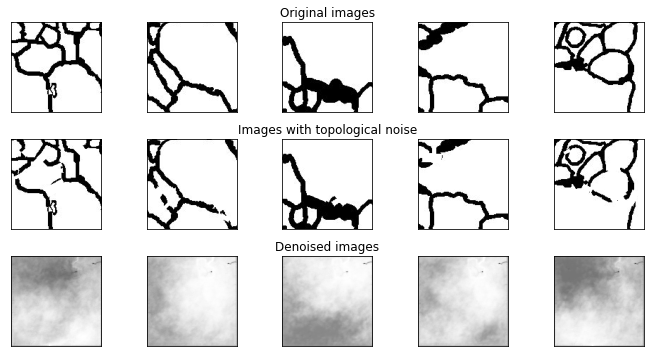

EPOCH 2/30
	 partial train loss (single batch 0): 0.168813
	 partial train loss (single batch 1): 0.169091
	 partial train loss (single batch 2): 0.171758
	 partial train loss (single batch 3): 0.150111
	 partial train loss (single batch 4): 0.161021
	 partial train loss (single batch 5): 0.170887
	 partial train loss (single batch 6): 0.179594
	 partial train loss (single batch 7): 0.166946
	 partial train loss (single batch 8): 0.187258
	 partial train loss (single batch 9): 0.181489
	 partial train loss (single batch 10): 0.157985
	 partial train loss (single batch 11): 0.185980
	 partial train loss (single batch 12): 0.166034
	 partial train loss (single batch 13): 0.156252
	 partial train loss (single batch 14): 0.185201
	 partial train loss (single batch 15): 0.170282
	 partial train loss (single batch 16): 0.171699
	 partial train loss (single batch 17): 0.154735
	 partial train loss (single batch 18): 0.188336
	 partial train loss (single batch 19): 0.198421
	 partial train los

	 partial train loss (single batch 166): 0.173731
	 partial train loss (single batch 167): 0.155378
	 partial train loss (single batch 168): 0.181734
	 partial train loss (single batch 169): 0.146129
	 partial train loss (single batch 170): 0.190486
	 partial train loss (single batch 171): 0.168387
	 partial train loss (single batch 172): 0.185269
	 partial train loss (single batch 173): 0.188754
	 partial train loss (single batch 174): 0.169491
	 partial train loss (single batch 175): 0.148154
	 partial train loss (single batch 176): 0.191195
	 partial train loss (single batch 177): 0.144674
	 partial train loss (single batch 178): 0.140950
	 partial train loss (single batch 179): 0.166853
	 partial train loss (single batch 180): 0.172981
	 partial train loss (single batch 181): 0.158143
	 partial train loss (single batch 182): 0.128801
	 partial train loss (single batch 183): 0.155095
	 partial train loss (single batch 184): 0.168930
	 partial train loss (single batch 185): 0.150350


	 partial train loss (single batch 330): 0.167300
	 partial train loss (single batch 331): 0.178558
	 partial train loss (single batch 332): 0.163995
	 partial train loss (single batch 333): 0.172742
	 partial train loss (single batch 334): 0.147934
	 partial train loss (single batch 335): 0.171825
	 partial train loss (single batch 336): 0.178079
	 partial train loss (single batch 337): 0.156008
	 partial train loss (single batch 338): 0.172251
	 partial train loss (single batch 339): 0.168537
	 partial train loss (single batch 340): 0.174136
	 partial train loss (single batch 341): 0.130356
	 partial train loss (single batch 342): 0.172465
	 partial train loss (single batch 343): 0.170621
	 partial train loss (single batch 344): 0.162344
	 partial train loss (single batch 345): 0.164416
	 partial train loss (single batch 346): 0.200378
	 partial train loss (single batch 347): 0.162059
	 partial train loss (single batch 348): 0.199722
	 partial train loss (single batch 349): 0.178135


	 partial train loss (single batch 494): 0.169397
	 partial train loss (single batch 495): 0.178943
	 partial train loss (single batch 496): 0.160987
	 partial train loss (single batch 497): 0.159073
	 partial train loss (single batch 498): 0.163866
	 partial train loss (single batch 499): 0.182578
	 partial train loss (single batch 500): 0.165271
	 partial train loss (single batch 501): 0.163437
	 partial train loss (single batch 502): 0.187961
	 partial train loss (single batch 503): 0.161236
	 partial train loss (single batch 504): 0.157206
	 partial train loss (single batch 505): 0.160287
	 partial train loss (single batch 506): 0.155612
	 partial train loss (single batch 507): 0.178191
	 partial train loss (single batch 508): 0.177278
	 partial train loss (single batch 509): 0.171539
	 partial train loss (single batch 510): 0.173537
	 partial train loss (single batch 511): 0.147415
	 partial train loss (single batch 512): 0.192959
	 partial train loss (single batch 513): 0.182082


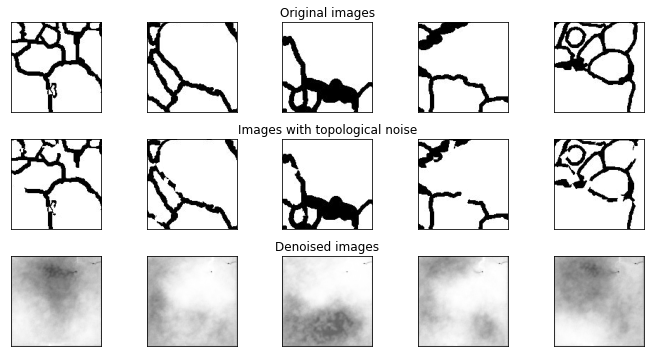

EPOCH 3/30
	 partial train loss (single batch 0): 0.165009
	 partial train loss (single batch 1): 0.164200
	 partial train loss (single batch 2): 0.166361
	 partial train loss (single batch 3): 0.147480
	 partial train loss (single batch 4): 0.156971
	 partial train loss (single batch 5): 0.166325
	 partial train loss (single batch 6): 0.176376
	 partial train loss (single batch 7): 0.161604
	 partial train loss (single batch 8): 0.182586
	 partial train loss (single batch 9): 0.176098
	 partial train loss (single batch 10): 0.153918
	 partial train loss (single batch 11): 0.181235
	 partial train loss (single batch 12): 0.162705
	 partial train loss (single batch 13): 0.153004
	 partial train loss (single batch 14): 0.177558
	 partial train loss (single batch 15): 0.165554
	 partial train loss (single batch 16): 0.168024
	 partial train loss (single batch 17): 0.150963
	 partial train loss (single batch 18): 0.185260
	 partial train loss (single batch 19): 0.193716
	 partial train los

	 partial train loss (single batch 166): 0.168915
	 partial train loss (single batch 167): 0.153314
	 partial train loss (single batch 168): 0.177622
	 partial train loss (single batch 169): 0.142549
	 partial train loss (single batch 170): 0.184910
	 partial train loss (single batch 171): 0.166952
	 partial train loss (single batch 172): 0.182158
	 partial train loss (single batch 173): 0.183102
	 partial train loss (single batch 174): 0.163043
	 partial train loss (single batch 175): 0.146354
	 partial train loss (single batch 176): 0.187516
	 partial train loss (single batch 177): 0.142133
	 partial train loss (single batch 178): 0.138460
	 partial train loss (single batch 179): 0.164907
	 partial train loss (single batch 180): 0.169359
	 partial train loss (single batch 181): 0.154238
	 partial train loss (single batch 182): 0.124442
	 partial train loss (single batch 183): 0.151810
	 partial train loss (single batch 184): 0.167219
	 partial train loss (single batch 185): 0.146327


	 partial train loss (single batch 330): 0.165693
	 partial train loss (single batch 331): 0.172932
	 partial train loss (single batch 332): 0.158960
	 partial train loss (single batch 333): 0.167528
	 partial train loss (single batch 334): 0.145380
	 partial train loss (single batch 335): 0.168951
	 partial train loss (single batch 336): 0.174579
	 partial train loss (single batch 337): 0.150459
	 partial train loss (single batch 338): 0.168652
	 partial train loss (single batch 339): 0.166986
	 partial train loss (single batch 340): 0.170401
	 partial train loss (single batch 341): 0.125662
	 partial train loss (single batch 342): 0.169664
	 partial train loss (single batch 343): 0.166929
	 partial train loss (single batch 344): 0.158259
	 partial train loss (single batch 345): 0.160924
	 partial train loss (single batch 346): 0.194706
	 partial train loss (single batch 347): 0.157798
	 partial train loss (single batch 348): 0.194990
	 partial train loss (single batch 349): 0.171888


	 partial train loss (single batch 494): 0.166461
	 partial train loss (single batch 495): 0.174821
	 partial train loss (single batch 496): 0.157208
	 partial train loss (single batch 497): 0.155162
	 partial train loss (single batch 498): 0.161093
	 partial train loss (single batch 499): 0.178513
	 partial train loss (single batch 500): 0.161380
	 partial train loss (single batch 501): 0.160042
	 partial train loss (single batch 502): 0.185705
	 partial train loss (single batch 503): 0.157258
	 partial train loss (single batch 504): 0.155026
	 partial train loss (single batch 505): 0.156820
	 partial train loss (single batch 506): 0.152207
	 partial train loss (single batch 507): 0.175526
	 partial train loss (single batch 508): 0.175239
	 partial train loss (single batch 509): 0.168780
	 partial train loss (single batch 510): 0.170949
	 partial train loss (single batch 511): 0.143325
	 partial train loss (single batch 512): 0.190147
	 partial train loss (single batch 513): 0.178459


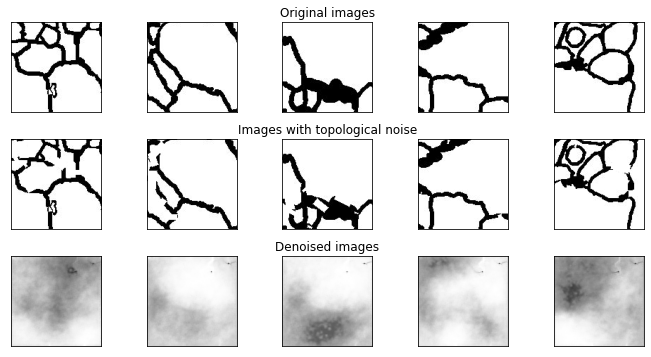

EPOCH 4/30
	 partial train loss (single batch 0): 0.162209
	 partial train loss (single batch 1): 0.161699
	 partial train loss (single batch 2): 0.164842
	 partial train loss (single batch 3): 0.146111
	 partial train loss (single batch 4): 0.153491
	 partial train loss (single batch 5): 0.163022
	 partial train loss (single batch 6): 0.172029
	 partial train loss (single batch 7): 0.157763
	 partial train loss (single batch 8): 0.179040
	 partial train loss (single batch 9): 0.171917
	 partial train loss (single batch 10): 0.150380
	 partial train loss (single batch 11): 0.173939
	 partial train loss (single batch 12): 0.159473
	 partial train loss (single batch 13): 0.149118
	 partial train loss (single batch 14): 0.174934
	 partial train loss (single batch 15): 0.162233
	 partial train loss (single batch 16): 0.162316
	 partial train loss (single batch 17): 0.147577
	 partial train loss (single batch 18): 0.181528
	 partial train loss (single batch 19): 0.190137
	 partial train los

	 partial train loss (single batch 166): 0.165247
	 partial train loss (single batch 167): 0.148624
	 partial train loss (single batch 168): 0.172524
	 partial train loss (single batch 169): 0.141314
	 partial train loss (single batch 170): 0.181399
	 partial train loss (single batch 171): 0.164305
	 partial train loss (single batch 172): 0.178612
	 partial train loss (single batch 173): 0.179832
	 partial train loss (single batch 174): 0.160849
	 partial train loss (single batch 175): 0.142571
	 partial train loss (single batch 176): 0.184322
	 partial train loss (single batch 177): 0.139665
	 partial train loss (single batch 178): 0.136658
	 partial train loss (single batch 179): 0.160886
	 partial train loss (single batch 180): 0.167494
	 partial train loss (single batch 181): 0.151910
	 partial train loss (single batch 182): 0.121729
	 partial train loss (single batch 183): 0.149658
	 partial train loss (single batch 184): 0.164768
	 partial train loss (single batch 185): 0.145487


	 partial train loss (single batch 330): 0.163018
	 partial train loss (single batch 331): 0.169858
	 partial train loss (single batch 332): 0.157233
	 partial train loss (single batch 333): 0.165265
	 partial train loss (single batch 334): 0.144507
	 partial train loss (single batch 335): 0.167237
	 partial train loss (single batch 336): 0.172090
	 partial train loss (single batch 337): 0.148196
	 partial train loss (single batch 338): 0.166732
	 partial train loss (single batch 339): 0.164659
	 partial train loss (single batch 340): 0.168833
	 partial train loss (single batch 341): 0.125501
	 partial train loss (single batch 342): 0.168502
	 partial train loss (single batch 343): 0.165860
	 partial train loss (single batch 344): 0.155736
	 partial train loss (single batch 345): 0.158776
	 partial train loss (single batch 346): 0.192788
	 partial train loss (single batch 347): 0.155400
	 partial train loss (single batch 348): 0.192583
	 partial train loss (single batch 349): 0.170080


	 partial train loss (single batch 494): 0.164109
	 partial train loss (single batch 495): 0.172679
	 partial train loss (single batch 496): 0.155110
	 partial train loss (single batch 497): 0.154727
	 partial train loss (single batch 498): 0.159923
	 partial train loss (single batch 499): 0.176178
	 partial train loss (single batch 500): 0.158854
	 partial train loss (single batch 501): 0.158156
	 partial train loss (single batch 502): 0.184082
	 partial train loss (single batch 503): 0.152857
	 partial train loss (single batch 504): 0.153375
	 partial train loss (single batch 505): 0.154471
	 partial train loss (single batch 506): 0.150235
	 partial train loss (single batch 507): 0.173871
	 partial train loss (single batch 508): 0.173949
	 partial train loss (single batch 509): 0.165586
	 partial train loss (single batch 510): 0.170023
	 partial train loss (single batch 511): 0.142818
	 partial train loss (single batch 512): 0.188487
	 partial train loss (single batch 513): 0.174663


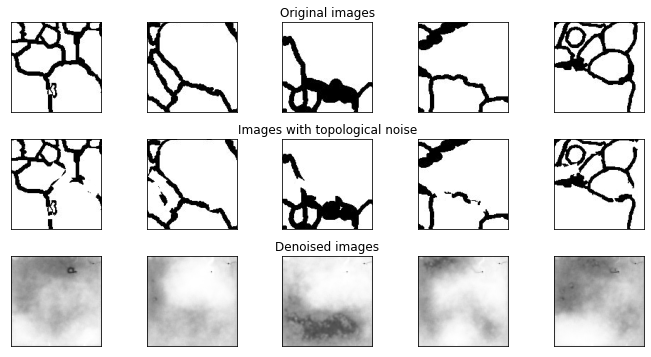

EPOCH 5/30
	 partial train loss (single batch 0): 0.160704
	 partial train loss (single batch 1): 0.160235
	 partial train loss (single batch 2): 0.162126
	 partial train loss (single batch 3): 0.145184
	 partial train loss (single batch 4): 0.154055
	 partial train loss (single batch 5): 0.162101
	 partial train loss (single batch 6): 0.169950
	 partial train loss (single batch 7): 0.154878
	 partial train loss (single batch 8): 0.178387
	 partial train loss (single batch 9): 0.170838
	 partial train loss (single batch 10): 0.150161
	 partial train loss (single batch 11): 0.173001
	 partial train loss (single batch 12): 0.158755
	 partial train loss (single batch 13): 0.148598
	 partial train loss (single batch 14): 0.173018
	 partial train loss (single batch 15): 0.162101
	 partial train loss (single batch 16): 0.159479
	 partial train loss (single batch 17): 0.146545
	 partial train loss (single batch 18): 0.180008
	 partial train loss (single batch 19): 0.190148
	 partial train los

	 partial train loss (single batch 166): 0.164283
	 partial train loss (single batch 167): 0.146816
	 partial train loss (single batch 168): 0.171059
	 partial train loss (single batch 169): 0.139514
	 partial train loss (single batch 170): 0.179099
	 partial train loss (single batch 171): 0.163000
	 partial train loss (single batch 172): 0.177172
	 partial train loss (single batch 173): 0.176576
	 partial train loss (single batch 174): 0.157730
	 partial train loss (single batch 175): 0.141780
	 partial train loss (single batch 176): 0.183523
	 partial train loss (single batch 177): 0.138071
	 partial train loss (single batch 178): 0.133712
	 partial train loss (single batch 179): 0.157893
	 partial train loss (single batch 180): 0.166237
	 partial train loss (single batch 181): 0.149808
	 partial train loss (single batch 182): 0.117642
	 partial train loss (single batch 183): 0.147397
	 partial train loss (single batch 184): 0.163699
	 partial train loss (single batch 185): 0.142257


	 partial train loss (single batch 330): 0.161342
	 partial train loss (single batch 331): 0.165993
	 partial train loss (single batch 332): 0.154067
	 partial train loss (single batch 333): 0.160937
	 partial train loss (single batch 334): 0.143850
	 partial train loss (single batch 335): 0.166969
	 partial train loss (single batch 336): 0.170912
	 partial train loss (single batch 337): 0.147658
	 partial train loss (single batch 338): 0.165649
	 partial train loss (single batch 339): 0.161481
	 partial train loss (single batch 340): 0.166752
	 partial train loss (single batch 341): 0.124540
	 partial train loss (single batch 342): 0.167871
	 partial train loss (single batch 343): 0.163677
	 partial train loss (single batch 344): 0.155041
	 partial train loss (single batch 345): 0.159093
	 partial train loss (single batch 346): 0.187734
	 partial train loss (single batch 347): 0.153170
	 partial train loss (single batch 348): 0.192427
	 partial train loss (single batch 349): 0.170694


	 partial train loss (single batch 494): 0.161183
	 partial train loss (single batch 495): 0.171775
	 partial train loss (single batch 496): 0.154063
	 partial train loss (single batch 497): 0.153488
	 partial train loss (single batch 498): 0.158775
	 partial train loss (single batch 499): 0.174886
	 partial train loss (single batch 500): 0.158371
	 partial train loss (single batch 501): 0.156704
	 partial train loss (single batch 502): 0.182507
	 partial train loss (single batch 503): 0.149881
	 partial train loss (single batch 504): 0.153490
	 partial train loss (single batch 505): 0.152803
	 partial train loss (single batch 506): 0.148497
	 partial train loss (single batch 507): 0.172997
	 partial train loss (single batch 508): 0.173958
	 partial train loss (single batch 509): 0.163400
	 partial train loss (single batch 510): 0.166739
	 partial train loss (single batch 511): 0.139429
	 partial train loss (single batch 512): 0.187815
	 partial train loss (single batch 513): 0.173001


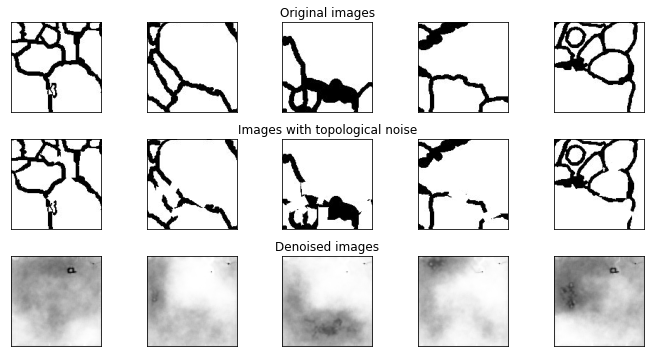

EPOCH 6/30
	 partial train loss (single batch 0): 0.159896
	 partial train loss (single batch 1): 0.159441
	 partial train loss (single batch 2): 0.161643
	 partial train loss (single batch 3): 0.143431
	 partial train loss (single batch 4): 0.152310
	 partial train loss (single batch 5): 0.163111
	 partial train loss (single batch 6): 0.168476
	 partial train loss (single batch 7): 0.156081
	 partial train loss (single batch 8): 0.177822
	 partial train loss (single batch 9): 0.167147
	 partial train loss (single batch 10): 0.149041
	 partial train loss (single batch 11): 0.172872
	 partial train loss (single batch 12): 0.157058
	 partial train loss (single batch 13): 0.148315
	 partial train loss (single batch 14): 0.171133
	 partial train loss (single batch 15): 0.160657
	 partial train loss (single batch 16): 0.157378
	 partial train loss (single batch 17): 0.143791
	 partial train loss (single batch 18): 0.177717
	 partial train loss (single batch 19): 0.188966
	 partial train los

	 partial train loss (single batch 166): 0.162528
	 partial train loss (single batch 167): 0.145488
	 partial train loss (single batch 168): 0.169423
	 partial train loss (single batch 169): 0.138277
	 partial train loss (single batch 170): 0.176383
	 partial train loss (single batch 171): 0.161698
	 partial train loss (single batch 172): 0.173000
	 partial train loss (single batch 173): 0.174062
	 partial train loss (single batch 174): 0.155407
	 partial train loss (single batch 175): 0.139564
	 partial train loss (single batch 176): 0.181006
	 partial train loss (single batch 177): 0.136913
	 partial train loss (single batch 178): 0.133096
	 partial train loss (single batch 179): 0.156839
	 partial train loss (single batch 180): 0.164566
	 partial train loss (single batch 181): 0.149993
	 partial train loss (single batch 182): 0.115681
	 partial train loss (single batch 183): 0.147285
	 partial train loss (single batch 184): 0.161738
	 partial train loss (single batch 185): 0.142589


	 partial train loss (single batch 330): 0.162512
	 partial train loss (single batch 331): 0.164319
	 partial train loss (single batch 332): 0.151993
	 partial train loss (single batch 333): 0.159781
	 partial train loss (single batch 334): 0.145357
	 partial train loss (single batch 335): 0.166481
	 partial train loss (single batch 336): 0.171953
	 partial train loss (single batch 337): 0.150036
	 partial train loss (single batch 338): 0.163733
	 partial train loss (single batch 339): 0.160929
	 partial train loss (single batch 340): 0.164649
	 partial train loss (single batch 341): 0.123728
	 partial train loss (single batch 342): 0.166492
	 partial train loss (single batch 343): 0.163618
	 partial train loss (single batch 344): 0.154792
	 partial train loss (single batch 345): 0.158045
	 partial train loss (single batch 346): 0.187960
	 partial train loss (single batch 347): 0.154337
	 partial train loss (single batch 348): 0.194397
	 partial train loss (single batch 349): 0.167843


	 partial train loss (single batch 494): 0.159600
	 partial train loss (single batch 495): 0.170562
	 partial train loss (single batch 496): 0.152786
	 partial train loss (single batch 497): 0.152544
	 partial train loss (single batch 498): 0.158454
	 partial train loss (single batch 499): 0.174934
	 partial train loss (single batch 500): 0.155979
	 partial train loss (single batch 501): 0.156723
	 partial train loss (single batch 502): 0.182354
	 partial train loss (single batch 503): 0.148309
	 partial train loss (single batch 504): 0.151852
	 partial train loss (single batch 505): 0.152307
	 partial train loss (single batch 506): 0.148899
	 partial train loss (single batch 507): 0.173815
	 partial train loss (single batch 508): 0.171354
	 partial train loss (single batch 509): 0.161191
	 partial train loss (single batch 510): 0.166455
	 partial train loss (single batch 511): 0.140600
	 partial train loss (single batch 512): 0.185850
	 partial train loss (single batch 513): 0.172167


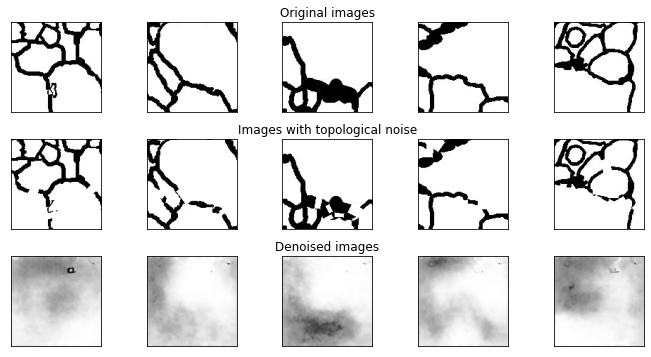

EPOCH 7/30
	 partial train loss (single batch 0): 0.159513
	 partial train loss (single batch 1): 0.158906
	 partial train loss (single batch 2): 0.161054
	 partial train loss (single batch 3): 0.141371
	 partial train loss (single batch 4): 0.149072
	 partial train loss (single batch 5): 0.158218
	 partial train loss (single batch 6): 0.167078
	 partial train loss (single batch 7): 0.152127
	 partial train loss (single batch 8): 0.174763
	 partial train loss (single batch 9): 0.165006
	 partial train loss (single batch 10): 0.147251
	 partial train loss (single batch 11): 0.169075
	 partial train loss (single batch 12): 0.157087
	 partial train loss (single batch 13): 0.146588
	 partial train loss (single batch 14): 0.169533
	 partial train loss (single batch 15): 0.159131
	 partial train loss (single batch 16): 0.156987
	 partial train loss (single batch 17): 0.143757
	 partial train loss (single batch 18): 0.174929
	 partial train loss (single batch 19): 0.185749
	 partial train los

	 partial train loss (single batch 166): 0.160411
	 partial train loss (single batch 167): 0.144190
	 partial train loss (single batch 168): 0.168155
	 partial train loss (single batch 169): 0.138111
	 partial train loss (single batch 170): 0.176297
	 partial train loss (single batch 171): 0.160636
	 partial train loss (single batch 172): 0.171673
	 partial train loss (single batch 173): 0.174317
	 partial train loss (single batch 174): 0.155543
	 partial train loss (single batch 175): 0.139891
	 partial train loss (single batch 176): 0.179491
	 partial train loss (single batch 177): 0.136185
	 partial train loss (single batch 178): 0.133615
	 partial train loss (single batch 179): 0.156310
	 partial train loss (single batch 180): 0.164208
	 partial train loss (single batch 181): 0.146437
	 partial train loss (single batch 182): 0.114097
	 partial train loss (single batch 183): 0.149369
	 partial train loss (single batch 184): 0.162782
	 partial train loss (single batch 185): 0.139672


	 partial train loss (single batch 330): 0.160646
	 partial train loss (single batch 331): 0.163754
	 partial train loss (single batch 332): 0.149385
	 partial train loss (single batch 333): 0.156394
	 partial train loss (single batch 334): 0.141902
	 partial train loss (single batch 335): 0.165479
	 partial train loss (single batch 336): 0.168510
	 partial train loss (single batch 337): 0.144809
	 partial train loss (single batch 338): 0.162250
	 partial train loss (single batch 339): 0.160705
	 partial train loss (single batch 340): 0.162272
	 partial train loss (single batch 341): 0.122671
	 partial train loss (single batch 342): 0.164793
	 partial train loss (single batch 343): 0.160873
	 partial train loss (single batch 344): 0.153667
	 partial train loss (single batch 345): 0.157783
	 partial train loss (single batch 346): 0.180695
	 partial train loss (single batch 347): 0.152370
	 partial train loss (single batch 348): 0.191977
	 partial train loss (single batch 349): 0.166473


	 partial train loss (single batch 494): 0.158241
	 partial train loss (single batch 495): 0.168778
	 partial train loss (single batch 496): 0.149973
	 partial train loss (single batch 497): 0.150694
	 partial train loss (single batch 498): 0.155649
	 partial train loss (single batch 499): 0.171775
	 partial train loss (single batch 500): 0.155110
	 partial train loss (single batch 501): 0.153946
	 partial train loss (single batch 502): 0.179696
	 partial train loss (single batch 503): 0.146422
	 partial train loss (single batch 504): 0.150342
	 partial train loss (single batch 505): 0.150824
	 partial train loss (single batch 506): 0.147103
	 partial train loss (single batch 507): 0.169642
	 partial train loss (single batch 508): 0.170756
	 partial train loss (single batch 509): 0.160332
	 partial train loss (single batch 510): 0.163798
	 partial train loss (single batch 511): 0.137938
	 partial train loss (single batch 512): 0.183308
	 partial train loss (single batch 513): 0.169776


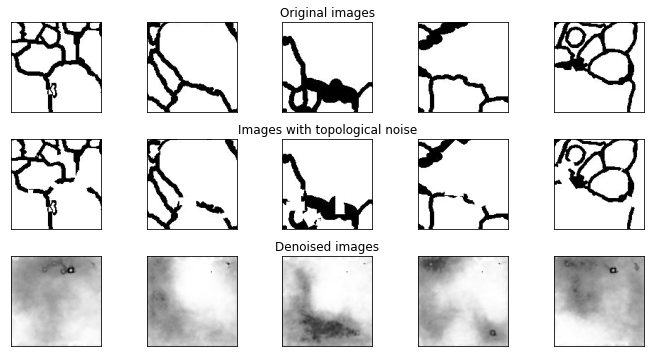

EPOCH 8/30
	 partial train loss (single batch 0): 0.157584
	 partial train loss (single batch 1): 0.155751
	 partial train loss (single batch 2): 0.158203
	 partial train loss (single batch 3): 0.144322
	 partial train loss (single batch 4): 0.150704
	 partial train loss (single batch 5): 0.159007
	 partial train loss (single batch 6): 0.167384
	 partial train loss (single batch 7): 0.152725
	 partial train loss (single batch 8): 0.172941
	 partial train loss (single batch 9): 0.165130
	 partial train loss (single batch 10): 0.150813
	 partial train loss (single batch 11): 0.170020
	 partial train loss (single batch 12): 0.155712
	 partial train loss (single batch 13): 0.145513
	 partial train loss (single batch 14): 0.168517
	 partial train loss (single batch 15): 0.161569
	 partial train loss (single batch 16): 0.156815
	 partial train loss (single batch 17): 0.141465
	 partial train loss (single batch 18): 0.174525
	 partial train loss (single batch 19): 0.183967
	 partial train los

	 partial train loss (single batch 166): 0.159735
	 partial train loss (single batch 167): 0.143196
	 partial train loss (single batch 168): 0.166117
	 partial train loss (single batch 169): 0.137856
	 partial train loss (single batch 170): 0.174884
	 partial train loss (single batch 171): 0.161074
	 partial train loss (single batch 172): 0.171917
	 partial train loss (single batch 173): 0.172095
	 partial train loss (single batch 174): 0.152989
	 partial train loss (single batch 175): 0.139044
	 partial train loss (single batch 176): 0.178925
	 partial train loss (single batch 177): 0.134071
	 partial train loss (single batch 178): 0.130168
	 partial train loss (single batch 179): 0.154684
	 partial train loss (single batch 180): 0.164425
	 partial train loss (single batch 181): 0.147665
	 partial train loss (single batch 182): 0.112211
	 partial train loss (single batch 183): 0.145879
	 partial train loss (single batch 184): 0.161031
	 partial train loss (single batch 185): 0.139601


	 partial train loss (single batch 330): 0.158417
	 partial train loss (single batch 331): 0.160999
	 partial train loss (single batch 332): 0.148981
	 partial train loss (single batch 333): 0.155430
	 partial train loss (single batch 334): 0.141299
	 partial train loss (single batch 335): 0.164359
	 partial train loss (single batch 336): 0.166842
	 partial train loss (single batch 337): 0.143861
	 partial train loss (single batch 338): 0.161592
	 partial train loss (single batch 339): 0.159427
	 partial train loss (single batch 340): 0.161845
	 partial train loss (single batch 341): 0.120587
	 partial train loss (single batch 342): 0.161845
	 partial train loss (single batch 343): 0.159368
	 partial train loss (single batch 344): 0.152268
	 partial train loss (single batch 345): 0.156956
	 partial train loss (single batch 346): 0.180848
	 partial train loss (single batch 347): 0.150791
	 partial train loss (single batch 348): 0.187674
	 partial train loss (single batch 349): 0.164300


	 partial train loss (single batch 494): 0.157382
	 partial train loss (single batch 495): 0.167875
	 partial train loss (single batch 496): 0.148726
	 partial train loss (single batch 497): 0.150721
	 partial train loss (single batch 498): 0.155154
	 partial train loss (single batch 499): 0.170539
	 partial train loss (single batch 500): 0.153860
	 partial train loss (single batch 501): 0.153834
	 partial train loss (single batch 502): 0.177478
	 partial train loss (single batch 503): 0.146188
	 partial train loss (single batch 504): 0.150005
	 partial train loss (single batch 505): 0.149215
	 partial train loss (single batch 506): 0.144704
	 partial train loss (single batch 507): 0.169521
	 partial train loss (single batch 508): 0.169689
	 partial train loss (single batch 509): 0.157569
	 partial train loss (single batch 510): 0.163161
	 partial train loss (single batch 511): 0.138338
	 partial train loss (single batch 512): 0.183098
	 partial train loss (single batch 513): 0.168377


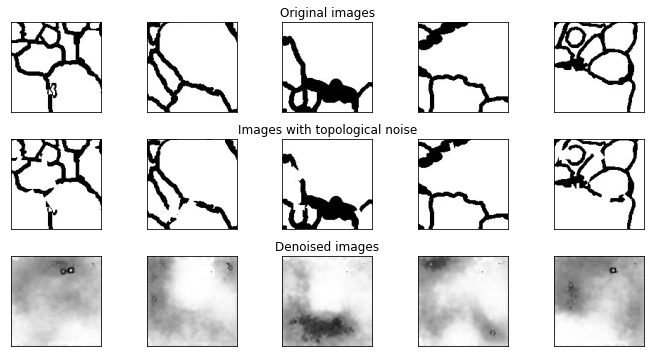

EPOCH 9/30
	 partial train loss (single batch 0): 0.155497
	 partial train loss (single batch 1): 0.157578
	 partial train loss (single batch 2): 0.159261
	 partial train loss (single batch 3): 0.145623
	 partial train loss (single batch 4): 0.147389
	 partial train loss (single batch 5): 0.155915
	 partial train loss (single batch 6): 0.167185
	 partial train loss (single batch 7): 0.152725
	 partial train loss (single batch 8): 0.172355
	 partial train loss (single batch 9): 0.163907
	 partial train loss (single batch 10): 0.145062
	 partial train loss (single batch 11): 0.168441
	 partial train loss (single batch 12): 0.155027
	 partial train loss (single batch 13): 0.146844
	 partial train loss (single batch 14): 0.165182
	 partial train loss (single batch 15): 0.156878
	 partial train loss (single batch 16): 0.155026
	 partial train loss (single batch 17): 0.141919
	 partial train loss (single batch 18): 0.173161
	 partial train loss (single batch 19): 0.183389
	 partial train los

	 partial train loss (single batch 166): 0.156581
	 partial train loss (single batch 167): 0.141157
	 partial train loss (single batch 168): 0.165828
	 partial train loss (single batch 169): 0.136861
	 partial train loss (single batch 170): 0.172512
	 partial train loss (single batch 171): 0.158728
	 partial train loss (single batch 172): 0.168160
	 partial train loss (single batch 173): 0.168807
	 partial train loss (single batch 174): 0.151282
	 partial train loss (single batch 175): 0.137635
	 partial train loss (single batch 176): 0.176991
	 partial train loss (single batch 177): 0.135239
	 partial train loss (single batch 178): 0.130085
	 partial train loss (single batch 179): 0.152516
	 partial train loss (single batch 180): 0.160316
	 partial train loss (single batch 181): 0.145600
	 partial train loss (single batch 182): 0.110722
	 partial train loss (single batch 183): 0.143319
	 partial train loss (single batch 184): 0.158515
	 partial train loss (single batch 185): 0.139592


	 partial train loss (single batch 330): 0.157658
	 partial train loss (single batch 331): 0.158895
	 partial train loss (single batch 332): 0.146308
	 partial train loss (single batch 333): 0.154889
	 partial train loss (single batch 334): 0.141408
	 partial train loss (single batch 335): 0.163326
	 partial train loss (single batch 336): 0.167505
	 partial train loss (single batch 337): 0.142810
	 partial train loss (single batch 338): 0.160963
	 partial train loss (single batch 339): 0.160266
	 partial train loss (single batch 340): 0.162251
	 partial train loss (single batch 341): 0.122217
	 partial train loss (single batch 342): 0.161348
	 partial train loss (single batch 343): 0.156695
	 partial train loss (single batch 344): 0.153137
	 partial train loss (single batch 345): 0.155922
	 partial train loss (single batch 346): 0.176418
	 partial train loss (single batch 347): 0.150458
	 partial train loss (single batch 348): 0.186972
	 partial train loss (single batch 349): 0.164805


	 partial train loss (single batch 494): 0.155533
	 partial train loss (single batch 495): 0.167259
	 partial train loss (single batch 496): 0.148695
	 partial train loss (single batch 497): 0.150331
	 partial train loss (single batch 498): 0.155680
	 partial train loss (single batch 499): 0.168635
	 partial train loss (single batch 500): 0.152393
	 partial train loss (single batch 501): 0.153728
	 partial train loss (single batch 502): 0.177798
	 partial train loss (single batch 503): 0.145513
	 partial train loss (single batch 504): 0.149191
	 partial train loss (single batch 505): 0.150134
	 partial train loss (single batch 506): 0.144628
	 partial train loss (single batch 507): 0.168442
	 partial train loss (single batch 508): 0.169929
	 partial train loss (single batch 509): 0.157335
	 partial train loss (single batch 510): 0.162343
	 partial train loss (single batch 511): 0.136646
	 partial train loss (single batch 512): 0.183924
	 partial train loss (single batch 513): 0.167554


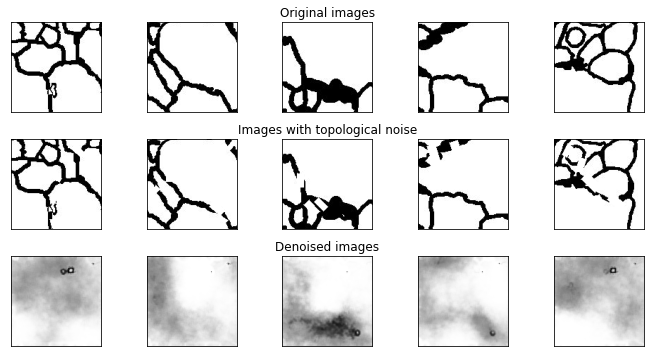

EPOCH 10/30
	 partial train loss (single batch 0): 0.156979
	 partial train loss (single batch 1): 0.154826
	 partial train loss (single batch 2): 0.156040
	 partial train loss (single batch 3): 0.141630
	 partial train loss (single batch 4): 0.146459
	 partial train loss (single batch 5): 0.156208
	 partial train loss (single batch 6): 0.166894
	 partial train loss (single batch 7): 0.148940
	 partial train loss (single batch 8): 0.170634
	 partial train loss (single batch 9): 0.160248
	 partial train loss (single batch 10): 0.143645
	 partial train loss (single batch 11): 0.167881
	 partial train loss (single batch 12): 0.152633
	 partial train loss (single batch 13): 0.142593
	 partial train loss (single batch 14): 0.163777
	 partial train loss (single batch 15): 0.157337
	 partial train loss (single batch 16): 0.154743
	 partial train loss (single batch 17): 0.139665
	 partial train loss (single batch 18): 0.170179
	 partial train loss (single batch 19): 0.181903
	 partial train lo

	 partial train loss (single batch 166): 0.156467
	 partial train loss (single batch 167): 0.140454
	 partial train loss (single batch 168): 0.163917
	 partial train loss (single batch 169): 0.136185
	 partial train loss (single batch 170): 0.170503
	 partial train loss (single batch 171): 0.157995
	 partial train loss (single batch 172): 0.168688
	 partial train loss (single batch 173): 0.167887
	 partial train loss (single batch 174): 0.151359
	 partial train loss (single batch 175): 0.136412
	 partial train loss (single batch 176): 0.176346
	 partial train loss (single batch 177): 0.134086
	 partial train loss (single batch 178): 0.127996
	 partial train loss (single batch 179): 0.152853
	 partial train loss (single batch 180): 0.159532
	 partial train loss (single batch 181): 0.144866
	 partial train loss (single batch 182): 0.109290
	 partial train loss (single batch 183): 0.144816
	 partial train loss (single batch 184): 0.157680
	 partial train loss (single batch 185): 0.136825


	 partial train loss (single batch 330): 0.156609
	 partial train loss (single batch 331): 0.158851
	 partial train loss (single batch 332): 0.146416
	 partial train loss (single batch 333): 0.152935
	 partial train loss (single batch 334): 0.139891
	 partial train loss (single batch 335): 0.161923
	 partial train loss (single batch 336): 0.167469
	 partial train loss (single batch 337): 0.142983
	 partial train loss (single batch 338): 0.160549
	 partial train loss (single batch 339): 0.158451
	 partial train loss (single batch 340): 0.160533
	 partial train loss (single batch 341): 0.122042
	 partial train loss (single batch 342): 0.161540
	 partial train loss (single batch 343): 0.158421
	 partial train loss (single batch 344): 0.150673
	 partial train loss (single batch 345): 0.154459
	 partial train loss (single batch 346): 0.179383
	 partial train loss (single batch 347): 0.149318
	 partial train loss (single batch 348): 0.187535
	 partial train loss (single batch 349): 0.164724


	 partial train loss (single batch 494): 0.155444
	 partial train loss (single batch 495): 0.167657
	 partial train loss (single batch 496): 0.148213
	 partial train loss (single batch 497): 0.148817
	 partial train loss (single batch 498): 0.155252
	 partial train loss (single batch 499): 0.167315
	 partial train loss (single batch 500): 0.153929
	 partial train loss (single batch 501): 0.153478
	 partial train loss (single batch 502): 0.176220
	 partial train loss (single batch 503): 0.144503
	 partial train loss (single batch 504): 0.148361
	 partial train loss (single batch 505): 0.148619
	 partial train loss (single batch 506): 0.144480
	 partial train loss (single batch 507): 0.168124
	 partial train loss (single batch 508): 0.167548
	 partial train loss (single batch 509): 0.157530
	 partial train loss (single batch 510): 0.162963
	 partial train loss (single batch 511): 0.136297
	 partial train loss (single batch 512): 0.182305
	 partial train loss (single batch 513): 0.165873


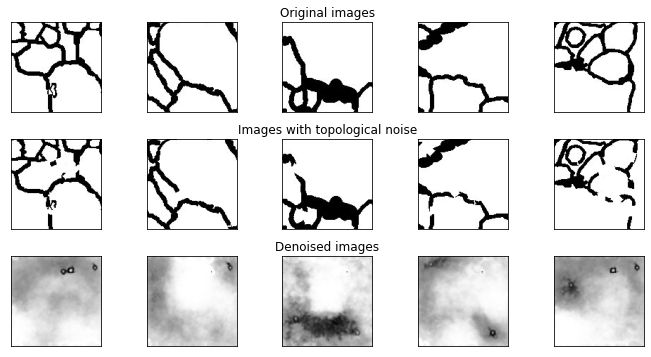

EPOCH 11/30
	 partial train loss (single batch 0): 0.154604
	 partial train loss (single batch 1): 0.153979
	 partial train loss (single batch 2): 0.155961
	 partial train loss (single batch 3): 0.141422
	 partial train loss (single batch 4): 0.147908
	 partial train loss (single batch 5): 0.154667
	 partial train loss (single batch 6): 0.164166
	 partial train loss (single batch 7): 0.148573
	 partial train loss (single batch 8): 0.169034
	 partial train loss (single batch 9): 0.160180
	 partial train loss (single batch 10): 0.143364
	 partial train loss (single batch 11): 0.165913
	 partial train loss (single batch 12): 0.152527
	 partial train loss (single batch 13): 0.143307
	 partial train loss (single batch 14): 0.162021
	 partial train loss (single batch 15): 0.155715
	 partial train loss (single batch 16): 0.153148
	 partial train loss (single batch 17): 0.138597
	 partial train loss (single batch 18): 0.168422
	 partial train loss (single batch 19): 0.180470
	 partial train lo

	 partial train loss (single batch 166): 0.157072
	 partial train loss (single batch 167): 0.141512
	 partial train loss (single batch 168): 0.165662
	 partial train loss (single batch 169): 0.137591
	 partial train loss (single batch 170): 0.173731
	 partial train loss (single batch 171): 0.156654
	 partial train loss (single batch 172): 0.168719
	 partial train loss (single batch 173): 0.168314
	 partial train loss (single batch 174): 0.150358
	 partial train loss (single batch 175): 0.137031
	 partial train loss (single batch 176): 0.175813
	 partial train loss (single batch 177): 0.134769
	 partial train loss (single batch 178): 0.128923
	 partial train loss (single batch 179): 0.152593
	 partial train loss (single batch 180): 0.159383
	 partial train loss (single batch 181): 0.143163
	 partial train loss (single batch 182): 0.107437
	 partial train loss (single batch 183): 0.141802
	 partial train loss (single batch 184): 0.157903
	 partial train loss (single batch 185): 0.140184


	 partial train loss (single batch 330): 0.157133
	 partial train loss (single batch 331): 0.158111
	 partial train loss (single batch 332): 0.146008
	 partial train loss (single batch 333): 0.156611
	 partial train loss (single batch 334): 0.139713
	 partial train loss (single batch 335): 0.162532
	 partial train loss (single batch 336): 0.165270
	 partial train loss (single batch 337): 0.143481
	 partial train loss (single batch 338): 0.159666
	 partial train loss (single batch 339): 0.159037
	 partial train loss (single batch 340): 0.158810
	 partial train loss (single batch 341): 0.122516
	 partial train loss (single batch 342): 0.160203
	 partial train loss (single batch 343): 0.159154
	 partial train loss (single batch 344): 0.154106
	 partial train loss (single batch 345): 0.155865
	 partial train loss (single batch 346): 0.174848
	 partial train loss (single batch 347): 0.148193
	 partial train loss (single batch 348): 0.186065
	 partial train loss (single batch 349): 0.163158


	 partial train loss (single batch 494): 0.154340
	 partial train loss (single batch 495): 0.167055
	 partial train loss (single batch 496): 0.150808
	 partial train loss (single batch 497): 0.150080
	 partial train loss (single batch 498): 0.155326
	 partial train loss (single batch 499): 0.166561
	 partial train loss (single batch 500): 0.154416
	 partial train loss (single batch 501): 0.153315
	 partial train loss (single batch 502): 0.176180
	 partial train loss (single batch 503): 0.143590
	 partial train loss (single batch 504): 0.148247
	 partial train loss (single batch 505): 0.148207
	 partial train loss (single batch 506): 0.142359
	 partial train loss (single batch 507): 0.168476
	 partial train loss (single batch 508): 0.167604
	 partial train loss (single batch 509): 0.157497
	 partial train loss (single batch 510): 0.162383
	 partial train loss (single batch 511): 0.136377
	 partial train loss (single batch 512): 0.184110
	 partial train loss (single batch 513): 0.167737


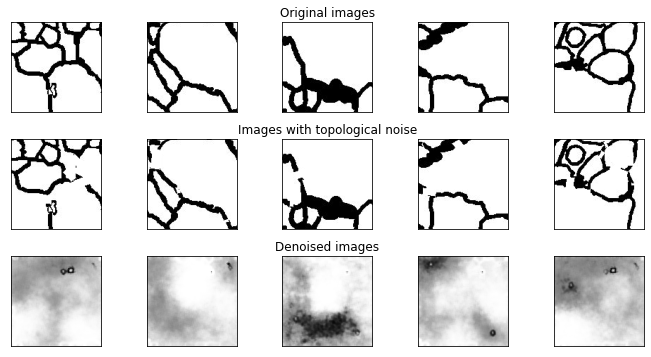

EPOCH 12/30
	 partial train loss (single batch 0): 0.154492
	 partial train loss (single batch 1): 0.154145
	 partial train loss (single batch 2): 0.153373
	 partial train loss (single batch 3): 0.141463
	 partial train loss (single batch 4): 0.145465
	 partial train loss (single batch 5): 0.153601
	 partial train loss (single batch 6): 0.163272
	 partial train loss (single batch 7): 0.147856
	 partial train loss (single batch 8): 0.170756
	 partial train loss (single batch 9): 0.160335
	 partial train loss (single batch 10): 0.142744
	 partial train loss (single batch 11): 0.165458
	 partial train loss (single batch 12): 0.151998
	 partial train loss (single batch 13): 0.142703
	 partial train loss (single batch 14): 0.162194
	 partial train loss (single batch 15): 0.155557
	 partial train loss (single batch 16): 0.154162
	 partial train loss (single batch 17): 0.138173
	 partial train loss (single batch 18): 0.169484
	 partial train loss (single batch 19): 0.179637
	 partial train lo

	 partial train loss (single batch 166): 0.155253
	 partial train loss (single batch 167): 0.140629
	 partial train loss (single batch 168): 0.164602
	 partial train loss (single batch 169): 0.136236
	 partial train loss (single batch 170): 0.170299
	 partial train loss (single batch 171): 0.156600
	 partial train loss (single batch 172): 0.166369
	 partial train loss (single batch 173): 0.166247
	 partial train loss (single batch 174): 0.146088
	 partial train loss (single batch 175): 0.135323
	 partial train loss (single batch 176): 0.175759
	 partial train loss (single batch 177): 0.134052
	 partial train loss (single batch 178): 0.126715
	 partial train loss (single batch 179): 0.151346
	 partial train loss (single batch 180): 0.158841
	 partial train loss (single batch 181): 0.144520
	 partial train loss (single batch 182): 0.107527
	 partial train loss (single batch 183): 0.141252
	 partial train loss (single batch 184): 0.157016
	 partial train loss (single batch 185): 0.137108


	 partial train loss (single batch 330): 0.155628
	 partial train loss (single batch 331): 0.156530
	 partial train loss (single batch 332): 0.143913
	 partial train loss (single batch 333): 0.150727
	 partial train loss (single batch 334): 0.141057
	 partial train loss (single batch 335): 0.163711
	 partial train loss (single batch 336): 0.164976
	 partial train loss (single batch 337): 0.143314
	 partial train loss (single batch 338): 0.158521
	 partial train loss (single batch 339): 0.157214
	 partial train loss (single batch 340): 0.160643
	 partial train loss (single batch 341): 0.120008
	 partial train loss (single batch 342): 0.159053
	 partial train loss (single batch 343): 0.155757
	 partial train loss (single batch 344): 0.149698
	 partial train loss (single batch 345): 0.154954
	 partial train loss (single batch 346): 0.174772
	 partial train loss (single batch 347): 0.147561
	 partial train loss (single batch 348): 0.183871
	 partial train loss (single batch 349): 0.161848


	 partial train loss (single batch 494): 0.155481
	 partial train loss (single batch 495): 0.166707
	 partial train loss (single batch 496): 0.146394
	 partial train loss (single batch 497): 0.147677
	 partial train loss (single batch 498): 0.154433
	 partial train loss (single batch 499): 0.167724
	 partial train loss (single batch 500): 0.152919
	 partial train loss (single batch 501): 0.152173
	 partial train loss (single batch 502): 0.175270
	 partial train loss (single batch 503): 0.141407
	 partial train loss (single batch 504): 0.147973
	 partial train loss (single batch 505): 0.148170
	 partial train loss (single batch 506): 0.143595
	 partial train loss (single batch 507): 0.166008
	 partial train loss (single batch 508): 0.168281
	 partial train loss (single batch 509): 0.154935
	 partial train loss (single batch 510): 0.160443
	 partial train loss (single batch 511): 0.134818
	 partial train loss (single batch 512): 0.180134
	 partial train loss (single batch 513): 0.164816


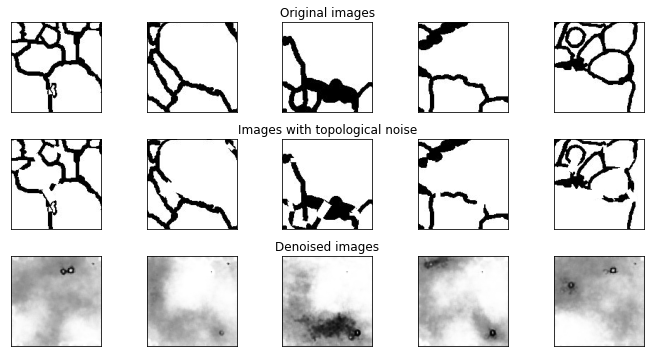

EPOCH 13/30
	 partial train loss (single batch 0): 0.153588
	 partial train loss (single batch 1): 0.151963
	 partial train loss (single batch 2): 0.151807
	 partial train loss (single batch 3): 0.141211
	 partial train loss (single batch 4): 0.144734
	 partial train loss (single batch 5): 0.151055
	 partial train loss (single batch 6): 0.161247
	 partial train loss (single batch 7): 0.146594
	 partial train loss (single batch 8): 0.167590
	 partial train loss (single batch 9): 0.158704
	 partial train loss (single batch 10): 0.142636
	 partial train loss (single batch 11): 0.164663
	 partial train loss (single batch 12): 0.151441
	 partial train loss (single batch 13): 0.140496
	 partial train loss (single batch 14): 0.158822
	 partial train loss (single batch 15): 0.154579
	 partial train loss (single batch 16): 0.153170
	 partial train loss (single batch 17): 0.137697
	 partial train loss (single batch 18): 0.167610
	 partial train loss (single batch 19): 0.177984
	 partial train lo

	 partial train loss (single batch 166): 0.153282
	 partial train loss (single batch 167): 0.139152
	 partial train loss (single batch 168): 0.160958
	 partial train loss (single batch 169): 0.135780
	 partial train loss (single batch 170): 0.168055
	 partial train loss (single batch 171): 0.156970
	 partial train loss (single batch 172): 0.164640
	 partial train loss (single batch 173): 0.164678
	 partial train loss (single batch 174): 0.148316
	 partial train loss (single batch 175): 0.134415
	 partial train loss (single batch 176): 0.173098
	 partial train loss (single batch 177): 0.132103
	 partial train loss (single batch 178): 0.125290
	 partial train loss (single batch 179): 0.149857
	 partial train loss (single batch 180): 0.158583
	 partial train loss (single batch 181): 0.142093
	 partial train loss (single batch 182): 0.104660
	 partial train loss (single batch 183): 0.139265
	 partial train loss (single batch 184): 0.156878
	 partial train loss (single batch 185): 0.134860


	 partial train loss (single batch 330): 0.155453
	 partial train loss (single batch 331): 0.153372
	 partial train loss (single batch 332): 0.144539
	 partial train loss (single batch 333): 0.148786
	 partial train loss (single batch 334): 0.139126
	 partial train loss (single batch 335): 0.161439
	 partial train loss (single batch 336): 0.166843
	 partial train loss (single batch 337): 0.141033
	 partial train loss (single batch 338): 0.156365
	 partial train loss (single batch 339): 0.157809
	 partial train loss (single batch 340): 0.162597
	 partial train loss (single batch 341): 0.120393
	 partial train loss (single batch 342): 0.158594
	 partial train loss (single batch 343): 0.154332
	 partial train loss (single batch 344): 0.149610
	 partial train loss (single batch 345): 0.152460
	 partial train loss (single batch 346): 0.171955
	 partial train loss (single batch 347): 0.144857
	 partial train loss (single batch 348): 0.183028
	 partial train loss (single batch 349): 0.161178


	 partial train loss (single batch 494): 0.154078
	 partial train loss (single batch 495): 0.164717
	 partial train loss (single batch 496): 0.145406
	 partial train loss (single batch 497): 0.147454
	 partial train loss (single batch 498): 0.154944
	 partial train loss (single batch 499): 0.166394
	 partial train loss (single batch 500): 0.151736
	 partial train loss (single batch 501): 0.151827
	 partial train loss (single batch 502): 0.174695
	 partial train loss (single batch 503): 0.140456
	 partial train loss (single batch 504): 0.147359
	 partial train loss (single batch 505): 0.149631
	 partial train loss (single batch 506): 0.142491
	 partial train loss (single batch 507): 0.168320
	 partial train loss (single batch 508): 0.166932
	 partial train loss (single batch 509): 0.153664
	 partial train loss (single batch 510): 0.158093
	 partial train loss (single batch 511): 0.134990
	 partial train loss (single batch 512): 0.179709
	 partial train loss (single batch 513): 0.166822


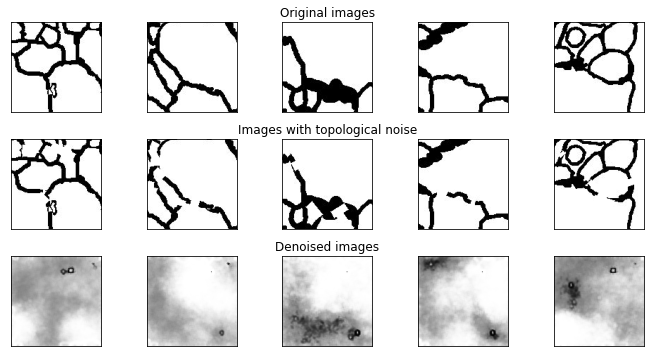

EPOCH 14/30
	 partial train loss (single batch 0): 0.152147
	 partial train loss (single batch 1): 0.150644
	 partial train loss (single batch 2): 0.152449
	 partial train loss (single batch 3): 0.141428
	 partial train loss (single batch 4): 0.144642
	 partial train loss (single batch 5): 0.151187
	 partial train loss (single batch 6): 0.163413
	 partial train loss (single batch 7): 0.148355
	 partial train loss (single batch 8): 0.168415
	 partial train loss (single batch 9): 0.157911
	 partial train loss (single batch 10): 0.143418
	 partial train loss (single batch 11): 0.163472
	 partial train loss (single batch 12): 0.152010
	 partial train loss (single batch 13): 0.141384
	 partial train loss (single batch 14): 0.156189
	 partial train loss (single batch 15): 0.154509
	 partial train loss (single batch 16): 0.153011
	 partial train loss (single batch 17): 0.139277
	 partial train loss (single batch 18): 0.169486
	 partial train loss (single batch 19): 0.178711
	 partial train lo

	 partial train loss (single batch 166): 0.151804
	 partial train loss (single batch 167): 0.139099
	 partial train loss (single batch 168): 0.160789
	 partial train loss (single batch 169): 0.135475
	 partial train loss (single batch 170): 0.168604
	 partial train loss (single batch 171): 0.155463
	 partial train loss (single batch 172): 0.163318
	 partial train loss (single batch 173): 0.161739
	 partial train loss (single batch 174): 0.145531
	 partial train loss (single batch 175): 0.132949
	 partial train loss (single batch 176): 0.173489
	 partial train loss (single batch 177): 0.131656
	 partial train loss (single batch 178): 0.124369
	 partial train loss (single batch 179): 0.150710
	 partial train loss (single batch 180): 0.157649
	 partial train loss (single batch 181): 0.141806
	 partial train loss (single batch 182): 0.103779
	 partial train loss (single batch 183): 0.137740
	 partial train loss (single batch 184): 0.155978
	 partial train loss (single batch 185): 0.134111


	 partial train loss (single batch 330): 0.156096
	 partial train loss (single batch 331): 0.153816
	 partial train loss (single batch 332): 0.145514
	 partial train loss (single batch 333): 0.149019
	 partial train loss (single batch 334): 0.139210
	 partial train loss (single batch 335): 0.161459
	 partial train loss (single batch 336): 0.161757
	 partial train loss (single batch 337): 0.140821
	 partial train loss (single batch 338): 0.154923
	 partial train loss (single batch 339): 0.154996
	 partial train loss (single batch 340): 0.159776
	 partial train loss (single batch 341): 0.120444
	 partial train loss (single batch 342): 0.155639
	 partial train loss (single batch 343): 0.155121
	 partial train loss (single batch 344): 0.147909
	 partial train loss (single batch 345): 0.154713
	 partial train loss (single batch 346): 0.172227
	 partial train loss (single batch 347): 0.145667
	 partial train loss (single batch 348): 0.181079
	 partial train loss (single batch 349): 0.159663


	 partial train loss (single batch 494): 0.152246
	 partial train loss (single batch 495): 0.162626
	 partial train loss (single batch 496): 0.146051
	 partial train loss (single batch 497): 0.146609
	 partial train loss (single batch 498): 0.152912
	 partial train loss (single batch 499): 0.163310
	 partial train loss (single batch 500): 0.150889
	 partial train loss (single batch 501): 0.151842
	 partial train loss (single batch 502): 0.174832
	 partial train loss (single batch 503): 0.138806
	 partial train loss (single batch 504): 0.145946
	 partial train loss (single batch 505): 0.146471
	 partial train loss (single batch 506): 0.140985
	 partial train loss (single batch 507): 0.165061
	 partial train loss (single batch 508): 0.165587
	 partial train loss (single batch 509): 0.152423
	 partial train loss (single batch 510): 0.158465
	 partial train loss (single batch 511): 0.134517
	 partial train loss (single batch 512): 0.178146
	 partial train loss (single batch 513): 0.162405


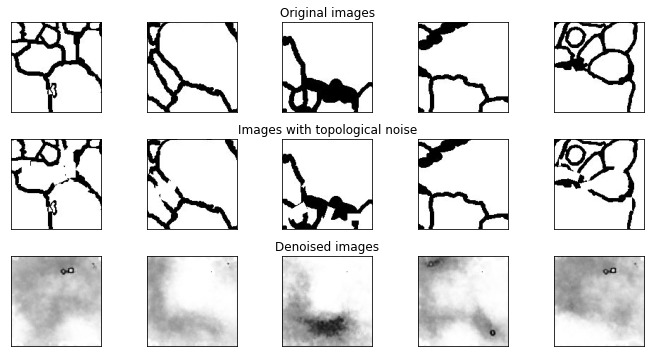

EPOCH 15/30
	 partial train loss (single batch 0): 0.152740
	 partial train loss (single batch 1): 0.151244
	 partial train loss (single batch 2): 0.151678
	 partial train loss (single batch 3): 0.141234
	 partial train loss (single batch 4): 0.143682
	 partial train loss (single batch 5): 0.150785
	 partial train loss (single batch 6): 0.162016
	 partial train loss (single batch 7): 0.149322
	 partial train loss (single batch 8): 0.168666
	 partial train loss (single batch 9): 0.157168
	 partial train loss (single batch 10): 0.140079
	 partial train loss (single batch 11): 0.164552
	 partial train loss (single batch 12): 0.151517
	 partial train loss (single batch 13): 0.141251
	 partial train loss (single batch 14): 0.159132
	 partial train loss (single batch 15): 0.153721
	 partial train loss (single batch 16): 0.150403
	 partial train loss (single batch 17): 0.135932
	 partial train loss (single batch 18): 0.164191
	 partial train loss (single batch 19): 0.177148
	 partial train lo

	 partial train loss (single batch 166): 0.157009
	 partial train loss (single batch 167): 0.136531
	 partial train loss (single batch 168): 0.159351
	 partial train loss (single batch 169): 0.135041
	 partial train loss (single batch 170): 0.167301
	 partial train loss (single batch 171): 0.154694
	 partial train loss (single batch 172): 0.161122
	 partial train loss (single batch 173): 0.161166
	 partial train loss (single batch 174): 0.144789
	 partial train loss (single batch 175): 0.133126
	 partial train loss (single batch 176): 0.172919
	 partial train loss (single batch 177): 0.131568
	 partial train loss (single batch 178): 0.124480
	 partial train loss (single batch 179): 0.151371
	 partial train loss (single batch 180): 0.158327
	 partial train loss (single batch 181): 0.141825
	 partial train loss (single batch 182): 0.102741
	 partial train loss (single batch 183): 0.136844
	 partial train loss (single batch 184): 0.154771
	 partial train loss (single batch 185): 0.134475


	 partial train loss (single batch 330): 0.153433
	 partial train loss (single batch 331): 0.154199
	 partial train loss (single batch 332): 0.141058
	 partial train loss (single batch 333): 0.145383
	 partial train loss (single batch 334): 0.138774
	 partial train loss (single batch 335): 0.162777
	 partial train loss (single batch 336): 0.161237
	 partial train loss (single batch 337): 0.140269
	 partial train loss (single batch 338): 0.152350
	 partial train loss (single batch 339): 0.155271
	 partial train loss (single batch 340): 0.157694
	 partial train loss (single batch 341): 0.118541
	 partial train loss (single batch 342): 0.154769
	 partial train loss (single batch 343): 0.151840
	 partial train loss (single batch 344): 0.146812
	 partial train loss (single batch 345): 0.154579
	 partial train loss (single batch 346): 0.169412
	 partial train loss (single batch 347): 0.145850
	 partial train loss (single batch 348): 0.181513
	 partial train loss (single batch 349): 0.160687


	 partial train loss (single batch 494): 0.150335
	 partial train loss (single batch 495): 0.158412
	 partial train loss (single batch 496): 0.144711
	 partial train loss (single batch 497): 0.146557
	 partial train loss (single batch 498): 0.152138
	 partial train loss (single batch 499): 0.163126
	 partial train loss (single batch 500): 0.149704
	 partial train loss (single batch 501): 0.150687
	 partial train loss (single batch 502): 0.173685
	 partial train loss (single batch 503): 0.137441
	 partial train loss (single batch 504): 0.147057
	 partial train loss (single batch 505): 0.145383
	 partial train loss (single batch 506): 0.140583
	 partial train loss (single batch 507): 0.164259
	 partial train loss (single batch 508): 0.165382
	 partial train loss (single batch 509): 0.151248
	 partial train loss (single batch 510): 0.159156
	 partial train loss (single batch 511): 0.134609
	 partial train loss (single batch 512): 0.178775
	 partial train loss (single batch 513): 0.164087


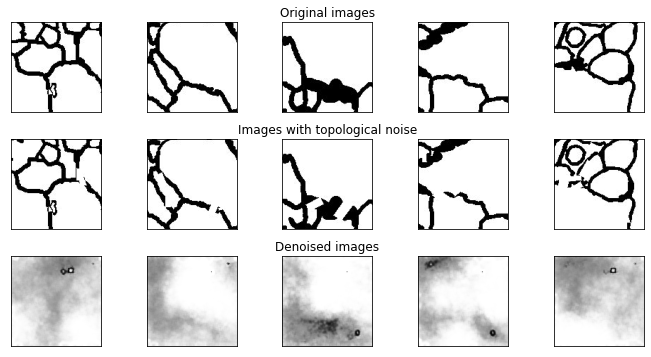

EPOCH 16/30
	 partial train loss (single batch 0): 0.154837
	 partial train loss (single batch 1): 0.150821
	 partial train loss (single batch 2): 0.150508
	 partial train loss (single batch 3): 0.139483
	 partial train loss (single batch 4): 0.141338
	 partial train loss (single batch 5): 0.150568
	 partial train loss (single batch 6): 0.160582
	 partial train loss (single batch 7): 0.144628
	 partial train loss (single batch 8): 0.164819
	 partial train loss (single batch 9): 0.155749
	 partial train loss (single batch 10): 0.139403
	 partial train loss (single batch 11): 0.162000
	 partial train loss (single batch 12): 0.149479
	 partial train loss (single batch 13): 0.140086
	 partial train loss (single batch 14): 0.153954
	 partial train loss (single batch 15): 0.152411
	 partial train loss (single batch 16): 0.149825
	 partial train loss (single batch 17): 0.134026
	 partial train loss (single batch 18): 0.163354
	 partial train loss (single batch 19): 0.175344
	 partial train lo

	 partial train loss (single batch 166): 0.152590
	 partial train loss (single batch 167): 0.135877
	 partial train loss (single batch 168): 0.158771
	 partial train loss (single batch 169): 0.134948
	 partial train loss (single batch 170): 0.167938
	 partial train loss (single batch 171): 0.154660
	 partial train loss (single batch 172): 0.160384
	 partial train loss (single batch 173): 0.161952
	 partial train loss (single batch 174): 0.145527
	 partial train loss (single batch 175): 0.131654
	 partial train loss (single batch 176): 0.172411
	 partial train loss (single batch 177): 0.130706
	 partial train loss (single batch 178): 0.122401
	 partial train loss (single batch 179): 0.150904
	 partial train loss (single batch 180): 0.157613
	 partial train loss (single batch 181): 0.142526
	 partial train loss (single batch 182): 0.103991
	 partial train loss (single batch 183): 0.137521
	 partial train loss (single batch 184): 0.154650
	 partial train loss (single batch 185): 0.132757


KeyboardInterrupt: 

In [24]:
history_da={'train_loss':[], 'test_loss':[]}
epochs = 30
batch_size = 10
for epoch in range(epochs):
    print('EPOCH %d/%d' % (epoch + 1, epochs))
    train_loss=train_epoch(
        model=autoencoder, 
        file_name=file_name,
        dataset_name_list=train_data_set_list,
        batch_size=batch_size,
        noise_mode=noise_mode,
        loss_fn=loss_function, 
        opt=optimizer)
    test_loss = test_epoch(
        model=autoencoder, 
        file_name=file_name,
        dataset_name_list=test_data_set_list,
        batch_size=batch_size,
        noise_mode=noise_mode,
        loss_fn=loss_function)
    history_da['train_loss'].append(train_loss)
    history_da['test_loss'].append(test_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t test loss {:.3f}'.format(epoch + 1, epochs, train_loss, test_loss))
    plot_outputs(autoencoder, file_name, test_data_set_list, noise_mode)